In [34]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import skimage.io as io
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

import cv2

In [2]:
datasets = ["train-20210503T055555Z-001/train"]

class_names = ["Black-grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse","Small-flowered Cranesbill","Sugar beet"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

nb_classes = len(class_names)
class_name_labels

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [3]:
from tqdm import tqdm

def load_data():
    images,labels = [],[]
    for dataset in datasets:

        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                
                img_path = os.path.join(os.path.join(dataset,folder),file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img,(150,150))
                
                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)
        labels = np.array(labels,dtype=np.float32)
        
        pass
    
    return images,labels
    pass

Loading the train data into 2 lists images and labels, each storing the image and its corresponding labels. 
The labels in this case are the type of seedlings as recorded in the dataset.

In [4]:
(train_images),(train_labels) = load_data()

100%|████████████████████████████████████████████████████████████████████████████████| 385/385 [00:05<00:00, 76.58it/s]


In [5]:
n_train = train_labels.shape[0]

_, train_count = np.unique(train_labels,return_counts=True)

df = pd.DataFrame(data = train_count)
# df = df.T
df['Index'] = class_names
df.columns = ['Train','Name']
df

,Train,Name
0,263,Black-grass
1,390,Charlock
2,287,Cleavers
3,611,Common Chickweed
4,221,Common wheat
5,475,Fat Hen
6,671,Loose Silky-bent
7,221,Maize
8,516,Scentless Mayweed
9,231,Shepherds Purse


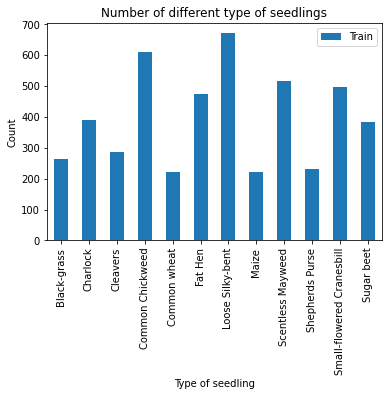

In [6]:
df.set_index("Name").plot.bar()
plt.xlabel("Type of seedling")
plt.ylabel("Count")
plt.title("Number of different type of seedlings");

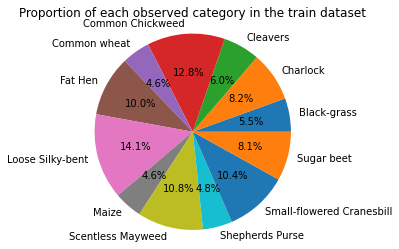

In [7]:
plt.pie(train_count,
       explode=(0,0,0,0,0,0,0,0,0,0,0,0),
       labels = class_names,
       autopct = "%1.1f%%")
plt.axis('equal')
plt.title("Proportion of each observed category in the train dataset")
plt.show();

In [8]:
def show_final_history(history):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title("Loss")
    ax[1].set_title("Accuracy")
    ax[0].plot(history.history["loss"],label="Loss")
    ax[0].plot(history.history["val_loss"],label="Test Loss")
    ax[1].plot(history.history["accuracy"],label="Accuracy")
    ax[1].plot(history.history["val_accuracy"],label="Test Accuracy")
    
    ax[0].legend(loc="upper right")
    ax[1].legend(loc="lower right")

In [9]:
train_labels

array([ 0.,  0.,  0., ..., 11., 11., 11.], dtype=float32)

In [10]:
train_labels.shape

(4767,)

In [11]:
train_y = train_labels

In [12]:
train_labels = to_categorical(train_labels,num_classes=nb_classes)

In [13]:
train_labels.shape

(4767, 12)

In [14]:
X_train,X_val,y_train,y_val = train_test_split(train_images,train_labels,test_size=0.3)

In [40]:
train_dir = "train-20210503T055555Z-001/train"

batch_size = 16

IGD = ImageDataGenerator(rescale=1./255,
                        horizontal_flip=True,
                        vertical_flip=True,
                        rotation_range=20)
#                         validation_split=0.3)

train_generator = IGD.flow(x=X_train,
                          y=y_train,
                          batch_size=batch_size,
                          shuffle=True,
                          seed=42)
#                           subset="training")

validation_generator = IGD.flow(x=X_val,
                               y=y_val,
                               batch_size=batch_size,
                               shuffle=True,
                               seed=42)
#                                subset="validation")

In [41]:
def conv_block(X,k,filters,stage,block,s=2):
    
    conv_base_name = 'res_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + "_branch"
    
    F1 = filters
    
    X = Conv2D(filters=F1,kernel_size=(k,k),strides=(s,s),
              padding='same',name=conv_base_name)(X)
    X = BatchNormalization(name=bn_base_name)(X)
#     X = MaxPooling2D((3,3))(X)
    X = Activation('relu')(X)
    
    return X
    pass

In [42]:
def conv_model(input_shape,classes):
    
    X_input = Input(input_shape)
    
    # Stage 1
    X = Conv2D(64,(5,5),strides=(2,2),name='conv1')(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
#     X = MaxPooling2D((3,3))(X)
#     X = Activation('relu')(X)
#     X = Dropout(0.1)(X)
    
    # Stage 2
    X = conv_block(X,5,64,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.1)(X)
    
    # Stage 3 
    X = conv_block(X,3,128,3,block='A',s=1)
    X = MaxPooling2D((3,3))(X)
    X = Dropout(0.1)(X)
    
    # Stage 4
    X = conv_block(X,5,256,4,block='A',s=1)
    X = Dropout(0.1)(X)
    
    # Output Layer
    X = Flatten()(X)
    X = Dense(256)(X)
    X = Dense(256)(X)
    X = Activation('relu')(X)
    X = Dense(classes,activation='softmax',name='fc'+str(classes))(X)
    
    model = Model(inputs=X_input,outputs=X,name='CNN')
    
    return model
    pass

In [43]:
model = conv_model(input_shape=(150,150,3),classes=nb_classes)

In [45]:
model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 73, 73, 64)        4864      
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 73, 73, 64)        256       
_________________________________________________________________
res_2A_branch (Conv2D)       (None, 73, 73, 64)        102464    
_________________________________________________________________
bn_2A_branch (BatchNormaliza (None, 73, 73, 64)        256       
_________________________________________________________________
activation_4 (Activation)    (None, 73, 73, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0       

In [46]:
opt = SGD(lr=0.0001,momentum=0.95)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [47]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,
                             save_best_only=True,mode="max")
callbacks_list = [checkpoint]

In [48]:
epochs = 125

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n//batch_size,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.n//batch_size,
                              callbacks=callbacks_list,
                              verbose=1)

c:\users\kgeethika\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/125
208/208 [==============================] - 234s 1s/step - loss: 2.3779 - accuracy: 0.2061 - val_loss: 4.4452 - val_accuracy: 0.1313

Epoch 00001: val_accuracy improved from -inf to 0.13132, saving model to model_weights.h5
Epoch 2/125
208/208 [==============================] - 234s 1s/step - loss: 1.3433 - accuracy: 0.5287 - val_loss: 5.6730 - val_accuracy: 0.0878

Epoch 00002: val_accuracy did not improve from 0.13132
Epoch 3/125
208/208 [==============================] - 232s 1s/step - loss: 1.0519 - accuracy: 0.6464 - val_loss: 2.1307 - val_accuracy: 0.3006

Epoch 00003: val_accuracy improved from 0.13132 to 0.30056, saving model to model_weights.h5
Epoch 4/125
208/208 [==============================] - 233s 1s/step - loss: 0.8638 - accuracy: 0.7122 - val_loss: 1.5370 - val_accuracy: 0.4951

Epoch 00004: val_accuracy improved from 0.30056 to 0.49508, saving model to model_weights.h5
Epoch 5/125
208/208 [==============================] - 230s 1s/step - loss: 0.7881 - accu

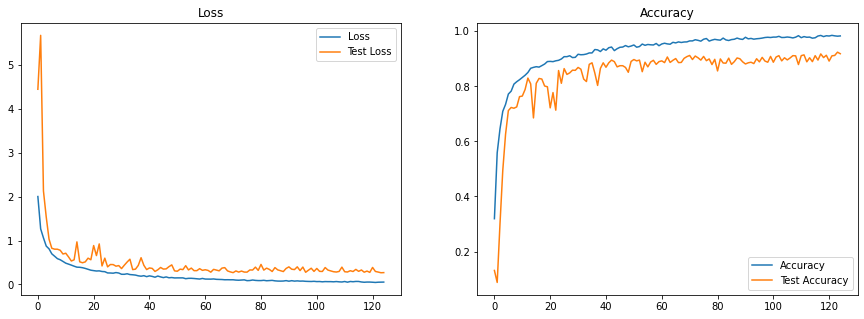

In [49]:
show_final_history(history)

In [50]:
class_name_labels

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [51]:
y_test = np.argmax(y_val,axis=1)
y_test.shape,validation_generator.n

((1431,), 1431)

In [52]:
val_pred = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in val_pred]

c:\users\kgeethika\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [53]:
y_pred = np.argmax(val_pred,axis=1)
y_pred.shape

(1431,)

<Figure size 432x288 with 0 Axes>

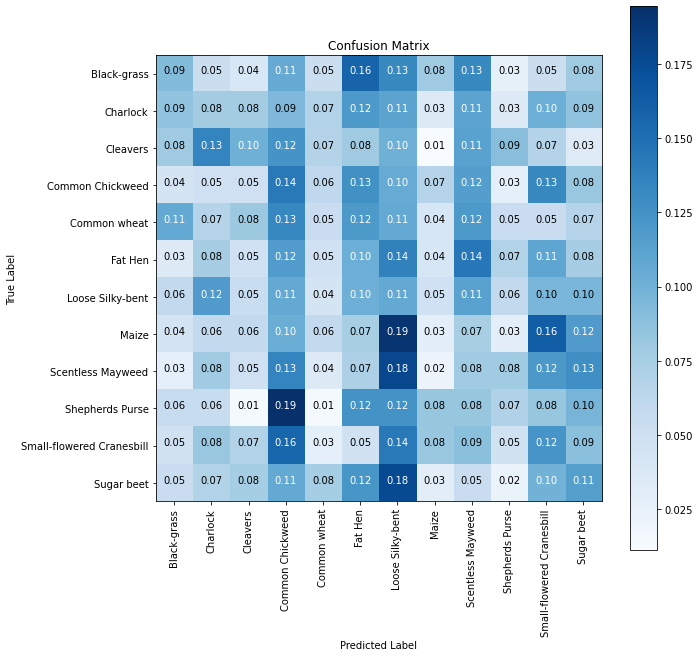

In [54]:
import itertools

def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)


plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.show()

In [89]:
test_dir = ["Part1"]

def load_test():
    
    images,names = [],[]
    for dataset in test_dir:

        for file in tqdm(os.listdir(dataset)):
            
            img_path = os.path.join(dataset,file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(150,150))

            images.append(img)
            names.append(file)
            pass
        
        images = np.array(images,dtype=np.float32)
        pass
    
    return images,names
    pass

In [90]:
(test_images),(test_names) = load_test()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.78it/s]


In [91]:
os.getcwd()

'D:\\Geethika\\AIML\\AIML\\Project Learning\\Computer vision'

In [92]:
os.path.abspath("Test Data - annotation.csv")

'D:\\Geethika\\AIML\\AIML\\Project Learning\\Computer vision\\Test Data - annotation.csv'

In [93]:
for (label),(i) in class_name_labels.items():
    print(label,i)

Black-grass 0
Charlock 1
Cleavers 2
Common Chickweed 3
Common wheat 4
Fat Hen 5
Loose Silky-bent 6
Maize 7
Scentless Mayweed 8
Shepherds Purse 9
Small-flowered Cranesbill 10
Sugar beet 11


In [94]:
test_images[0].shape

(150, 150, 3)

In [96]:
from tensorflow.keras.preprocessing.image import img_to_array

predicted_class = []
class_labels = dict((i,label) for label,i in class_name_labels.items())
for image in tqdm(test_images):
    
    image = np.expand_dims(image, axis=0)
    test_result = model.predict(image)
    pred_class = np.argmax(test_result,axis=1)
    prediction = [class_labels[k] for k in pred_class][0]
    predicted_class.append(prediction)
    pass

results = pd.DataFrame({"file":test_names,
                        "species":predicted_class})

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


In [97]:
results.head()

,file,species
0,Predict.png,Maize


In [98]:
results.to_csv("submission.csv",index=False)

In [99]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    pass

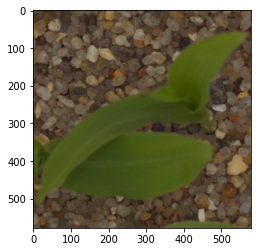

In [106]:
# Read the image
img = io.imread('Part1\Predict.png')

plt.imshow(img)
plt.show()

In [3]:
test = pd.read_csv('Test Data - annotation.csv')
test.head()

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet


In [17]:
import pandas as pd 
import numpy as np 

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc, precision_recall_fscore_support 
import matplotlib.pyplot as plt 
import h5py 
from sklearn.neighbors import KNeighborsClassifier


In [50]:
X_train,X_val,y_train,y_val = train_test_split(train_images,train_labels,test_size=0.3,random_state = 42)
# train_images, test_images, train_labels, test_labels

In [51]:
print("Training set feature shape", X_train.shape) 
print("Training set target shape", y_train.shape) 
print("Validation set feature shape", X_val.shape) 
print("Validation set target shape", y_val.shape)


Training set feature shape (3336, 150, 150, 3)
Training set target shape (3336,)
Validation set feature shape (1431, 150, 150, 3)
Validation set target shape (1431,)


In [68]:
X_train = X_train.reshape(3336,3*150*150)
X_test = X_val.reshape(1431,3*150*150)

In [69]:
X_train.shape

(3336, 67500)

In [29]:
nsamples, nx, ny,nz = X_train.shape
X_train_reshaped = X_train.reshape((nsamples,nx*ny*nz))

In [31]:
nsamples, nx, ny,nz = X_val.shape
print(X_val.shape)
X_val_reshaped = X_val.reshape((nsamples,nx*ny*nz))
print(X_val_reshaped.shape)

(1431, 150, 150, 3)
(1431, 67500)


In [52]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_reshaped, y_train)

c:\users\kgeethika\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [56]:
y_pred = logreg.predict(X_val_reshaped)

In [58]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
LOG_accuracy=accuracy_score(y_val, y_pred)
LOG_accuracy

0.10202655485674354

<AxesSubplot:>

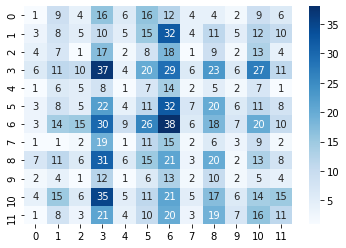

In [59]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm_log = confusion_matrix(y_val, y_pred)
sns.heatmap(cm_log, annot=True, cmap='Blues', fmt='g')


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Flatten

In [24]:
model = Sequential()

In [25]:
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(12, activation="softmax"))

In [28]:
# Compile the model
model.compile(loss="mse", metrics=["accuracy"], optimizer="sgd")

# Fit the model
model.fit(x=X_train, y=y_train, batch_size=12, epochs=6, validation_data=(X_val, y_val))

Epoch 1/6
278/278 [==============================] - 9s 31ms/step - loss: 0.0755 - accuracy: 0.1327 - val_loss: 0.0754 - val_accuracy: 0.1440
Epoch 2/6
278/278 [==============================] - 9s 31ms/step - loss: 0.0755 - accuracy: 0.1359 - val_loss: 0.0754 - val_accuracy: 0.1440
Epoch 3/6
278/278 [==============================] - 9s 31ms/step - loss: 0.0755 - accuracy: 0.1334 - val_loss: 0.0754 - val_accuracy: 0.1440
Epoch 4/6
278/278 [==============================] - 9s 32ms/step - loss: 0.0755 - accuracy: 0.1450 - val_loss: 0.0754 - val_accuracy: 0.1440
Epoch 5/6
278/278 [==============================] - 8s 30ms/step - loss: 0.0755 - accuracy: 0.1365 - val_loss: 0.0754 - val_accuracy: 0.1440
Epoch 6/6
278/278 [==============================] - 8s 29ms/step - loss: 0.0756 - accuracy: 0.1422 - val_loss: 0.0754 - val_accuracy: 0.1440


In [30]:
results = model.evaluate(X_val, y_val)

45/45 [==============================] - 1s 11ms/step - loss: 0.0754 - accuracy: 0.1440


In [31]:
print ("Accuracy:" ,results)

Accuracy: [0.07544167339801788, 0.1439552754163742]


In [32]:
print(model.metrics_names)

['loss', 'accuracy']


In [35]:
model = Sequential()
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(12, activation="softmax"))
model.add(BatchNormalization(input_shape=(12,)))

In [36]:
model.compile(optimizer='sgd', loss='mse')

In [38]:
model.fit(X_train, y_train, epochs=100, validation_split=0.35)

Epoch 1/100
68/68 [==============================] - 3s 42ms/step - loss: 0.1186 - val_loss: 0.1174
Epoch 2/100
68/68 [==============================] - 3s 42ms/step - loss: 0.0814 - val_loss: 0.0976
Epoch 3/100
68/68 [==============================] - 3s 40ms/step - loss: 0.0802 - val_loss: 0.0875
Epoch 4/100
68/68 [==============================] - 3s 38ms/step - loss: 0.0792 - val_loss: 0.0823
Epoch 5/100
68/68 [==============================] - 3s 40ms/step - loss: 0.0785 - val_loss: 0.0796
Epoch 6/100
68/68 [==============================] - 3s 42ms/step - loss: 0.0778 - val_loss: 0.0781
Epoch 7/100
68/68 [==============================] - 3s 43ms/step - loss: 0.0774 - val_loss: 0.0772
Epoch 8/100
68/68 [==============================] - 3s 39ms/step - loss: 0.0769 - val_loss: 0.0767
Epoch 9/100
68/68 [==============================] - 3s 40ms/step - loss: 0.0767 - val_loss: 0.0764
Epoch 10/100
68/68 [==============================] - 3s 42ms/step - loss: 0.0764 - val_loss: 0.0762

In [41]:
results = model.evaluate(X_val, y_val)

45/45 [==============================] - 1s 12ms/step - loss: 0.0754


In [42]:
print('Test accuracy: ', results)

Test accuracy:  0.07543247193098068
